# Optimal Storage for average years: Result graphs

This notebook produces the graphs for the core simulations as provided in the paper "result" section

## Packages and options

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


In [12]:
map_countries = {
    "FR": "France",
    "DE": "Germany",
    "GR": "Greece",
}
countries = list(map_countries.keys())

In [13]:
fn_renewable: str = "../data/renewables_ninja.parquet"
fn_demand: str = "../data/renewables_with_load.parquet"


years = range(2015, 2020)
# TODO DO NOT CHANGE NEXT LINE
total_demand = 100 # DO NOT CHANGE THIS ==> ENSURES % interpretation
steps = 100 # number of steps for renewable shares

In [14]:
fn_opt = "../results/df_storage_need_given.parquet"
fn_given = "../results/df_storage_need_opt.parquet"

## Get results

In [15]:
df_given = pd.read_parquet(fn_given)
df_opt = pd.read_parquet(fn_opt)

In [16]:
total_demand = 100
df_agg_opt = (
    df_opt.groupby(["country", "renewableDemandShare"], as_index=False)[
        ["MAX_STO", "shareWind"]
    ]
    .mean()
    .assign(
        # convert to percentage and set RE share to zero for non-renewable scenarios
        shareWind=lambda df: (df["renewableDemandShare"] > 0).astype(int)
        * df["shareWind"]
        * 100,
        renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int),
        MAX_STO=lambda df: df["MAX_STO"] / total_demand * 100,
    )
    # .round(2)
)

df_agg_given = (
    df_given.groupby(["country", "renewableDemandShare"], as_index=False)[
        ["MAX_STO", "shareWind"]
    ]
    .mean()
    .assign(
        # convert to percentage and set RE share to zero for non-renewable scenarios
        shareWind=lambda df: (df["renewableDemandShare"] > 0).astype(int)
        * df["shareWind"]
        * 100,
        renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int),
        MAX_STO=lambda df: df["MAX_STO"] / total_demand * 100,
    )
    # .round(2)
)

## Plots

### Storage and renewable share by scenario

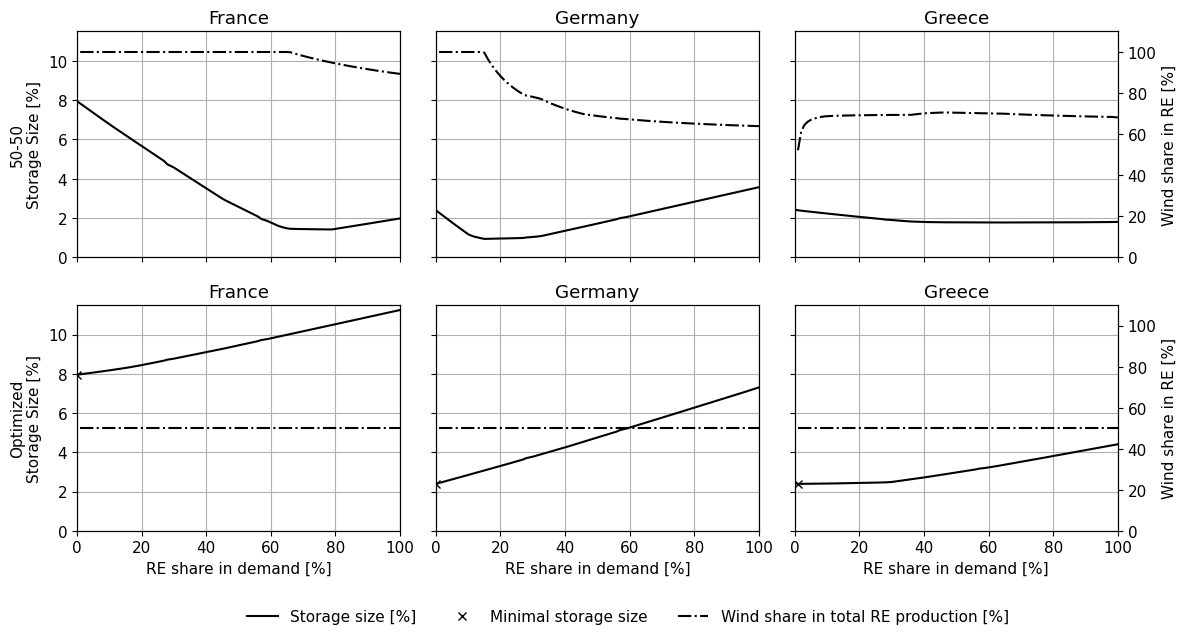

In [17]:
mpl.rcParams["font.size"] = 11
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
for i, (ax, country) in enumerate(zip(axs[0], countries)):
    df_p = df_agg_given.query(f"country == '{country}'")
    sns.lineplot(
        x="renewableDemandShare",
        y="MAX_STO",
        data=df_p,
        ax=ax,
        color="black",
        linestyle="-",
        label="Storage size",
    )
    ax.set_title(f"{map_countries[country]}")
    ax.set_xlabel("RE share in demand [%]")
    ax.set_ylabel("50-50\nStorage Size [%]")
    ax.set_ylim(0, 11.5)
    ax2 = ax.twinx()
    sns.lineplot(
        x="renewableDemandShare",
        y="shareWind",
        data=df_p[df_p["renewableDemandShare"] > 0],
        ax=ax2,
        color="black",
        linestyle="-.",
        label="Wind share in total RE production",
    )
    if i == len(countries) - 1:
        ax2.set_ylabel("Wind share in RE [%]")
    else:
        ax2.get_yaxis().set_ticks([])
        ax2.set_ylabel("")
    ax2.set_ylim(0, 110)
    ax.grid()
    ax.set_xlim(0, 100)
    ax.get_legend().remove()
    ax2.get_legend().remove()

for i, (ax, country) in enumerate(zip(axs[1], countries)):
    df_p = df_agg_opt.query(f"country == '{country}'")
    sns.lineplot(
        x="renewableDemandShare",
        y="MAX_STO",
        data=df_p,
        ax=ax,
        color="black",
        linestyle="-",
        label="Storage size [%]",
    )
    ax.set_title(f"{map_countries[country]}")
    ax.set_xlabel("RE share in demand [%]")
    ax.set_ylabel("Optimized\nStorage Size [%]")
    ax.set_ylim(0, 11.5)
    ax2 = ax.twinx()
    sns.lineplot(
        x="renewableDemandShare",
        y="shareWind",
        data=df_p[df_p["renewableDemandShare"] > 0],
        ax=ax2,
        color="black",
        linestyle="-.",
        label="Wind share in total RE production [%]",
    )
    if i == len(countries) - 1:
        ax2.set_ylabel("Wind share in RE [%]")
    else:
        ax2.get_yaxis().set_ticks([])
        ax2.set_ylabel("")
    ax2.set_ylim(0, 110)
    ax.grid()
    ax.set_xlim(0, 100)
    ax.get_legend().remove()
    ax2.get_legend().remove()
    # get the minimal storage size for the optimized scenario and mark it with
    # a cross
    id_min = df_p["MAX_STO"].idxmin()
    min_storage = df_p.loc[id_min, "MAX_STO"]
    min_re_share = df_p.loc[id_min, "renewableDemandShare"]
    ax.plot(min_re_share, min_storage, "kx", label="Minimal storage size")


# make a common legend merging the two legends
l1, la1 = ax.get_legend_handles_labels()
l2, la2 = ax2.get_legend_handles_labels()
fig.legend(
    l1 + l2,
    la1 + la2,
    loc="lower left",
    ncol=3,
    bbox_to_anchor=(0.2, -0.075),
    frameon=False,
)
plt.tight_layout()
plt.savefig("../figures/storage_need_average_share.png", dpi=300, bbox_inches="tight")

### Boxplots

In [18]:
def boxplot_by_week(
    df: pd.DataFrame,
    countries: list[str],
    re_shares: list[float],
    y_var: str = "netSupply",
    y_label: str = "Hourly net-generation [MWh]",
    y_range: tuple[float, float] = (-0.02, 0.02),
    mark_zero: bool = True,
    fn_out: str | None = None,
):
    """Provide boxplot of weekly distribution

    Args:
        df (pd.DataFrame): DataFrame with the data
        countries (list[str]): List of countries to plot
        re_shares (list[float]): List of renewable shares to plot
        y_var (str, optional): Variable to plot.
            Defaults to "netSupply".
        y_label (str, optional): Label for the y-axis.
            Defaults to "Hourly net-generation [MWh]".
        y_range (tuple[float, float], optional): Range for the y-axis.
            Defaults to (-0.02, 0.02).
        mark_zero (bool, optional): Mark zero on the y-axis with a straight line.
            Defaults to True.
        fn_out (str | None, optional): Filename to save the plot.
            Defaults to None.
    """
    _, axs = plt.subplots(len(re_shares), len(countries), figsize=(24, 12), sharey=True)
    PROPS = {
        "boxprops": {"facecolor": "none", "edgecolor": "black"},
        "medianprops": {"color": "black"},
        "whiskerprops": {"color": "black"},
        "capprops": {"color": "black"},
    }

    for i, country in enumerate(countries):
        for j, re_share in enumerate(re_shares):
            ax = axs[j, i]
            df_p = df.query(
                f"country == '{country}' and renewableDemandShare == {re_share}"
            ).assign(
                week=lambda x: x.index.isocalendar().week,
                day=lambda x: x.index.dayofyear,
                month=lambda x: x.index.month,
            )

            ax.set_xlim(0.5, 51)
            ax.set_ylim(*y_range)
            if mark_zero:
                ax.hlines(0, -1, 52, color="gray", linestyle="-")
            sns.boxplot(df_p, x="week", y=y_var, ax=ax, **PROPS)
            if j == 0:
                ax.set_title(f"{map_countries[country]}")
            if j == len(re_shares) - 1:
                ax.set_xlabel("Week of the year")
                ax.xaxis.set_major_locator(plt.MaxNLocator(12))
            else:
                ax.set_xlabel("")
                # remove xticks
                ax.set_xticks([])

            ax.set_ylabel(f"Renewable Share: {int(re_share*100)}%\n {y_label}")
    plt.tight_layout()
    if fn_out is not None:
        plt.savefig(fn_out, dpi=300, bbox_inches="tight")

#### Storage usage

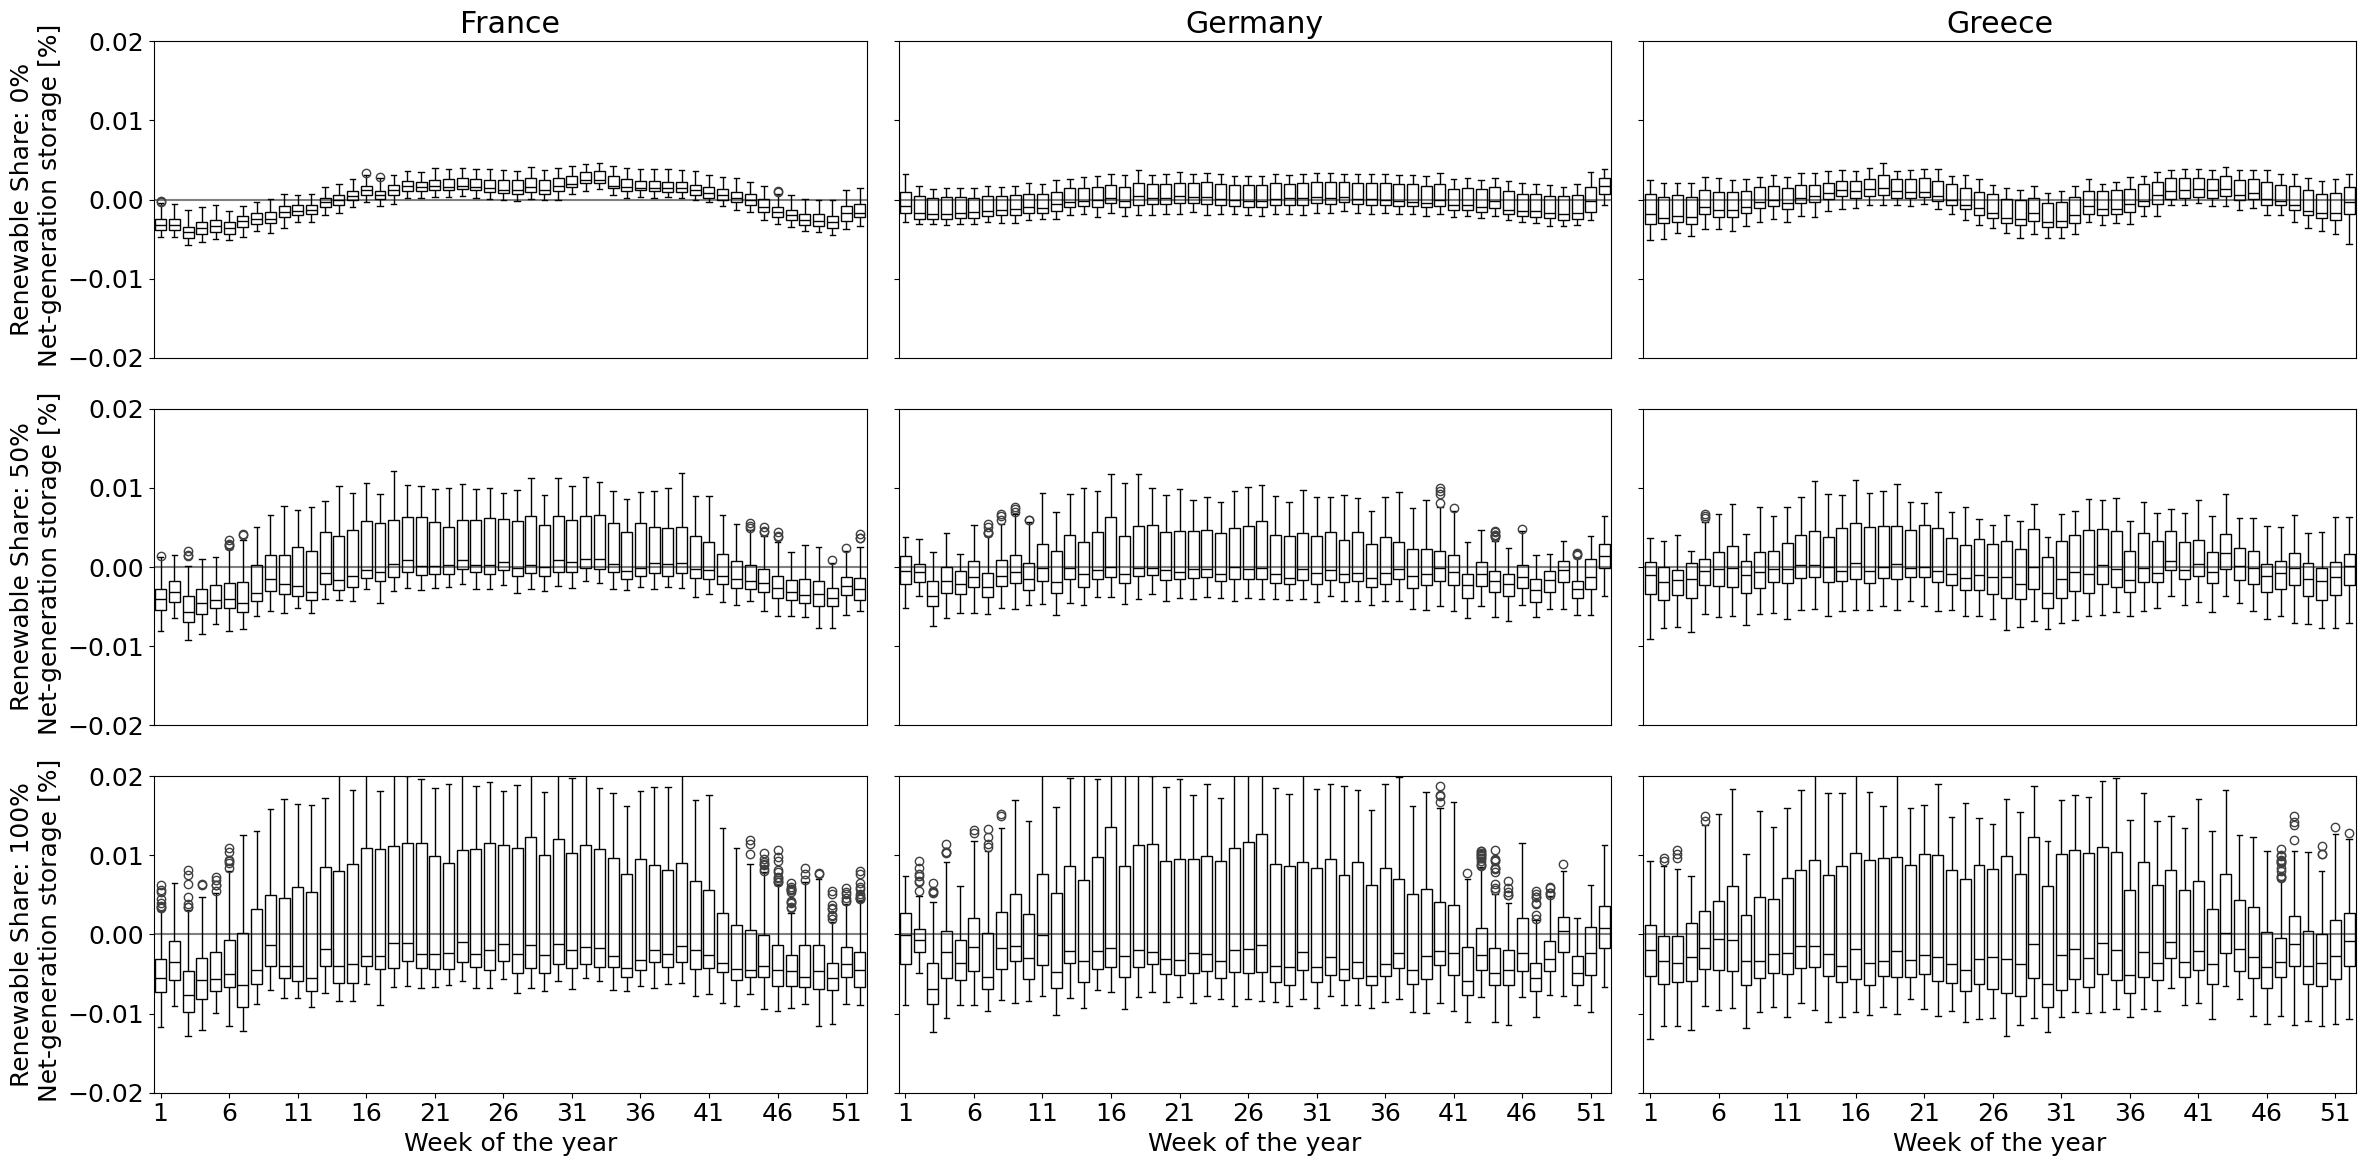

In [19]:
mpl.rcParams["font.size"] = 18
re_shares = [0, 0.5, 1]

y_var = "netSupply"
y_label = "Net-generation storage [%]"

boxplot_by_week(
    df_opt,
    countries,
    re_shares,
    y_var=y_var,
    y_label=y_label,
    fn_out="../figures/net_generation_boxplot.png",
)

#### Storage level

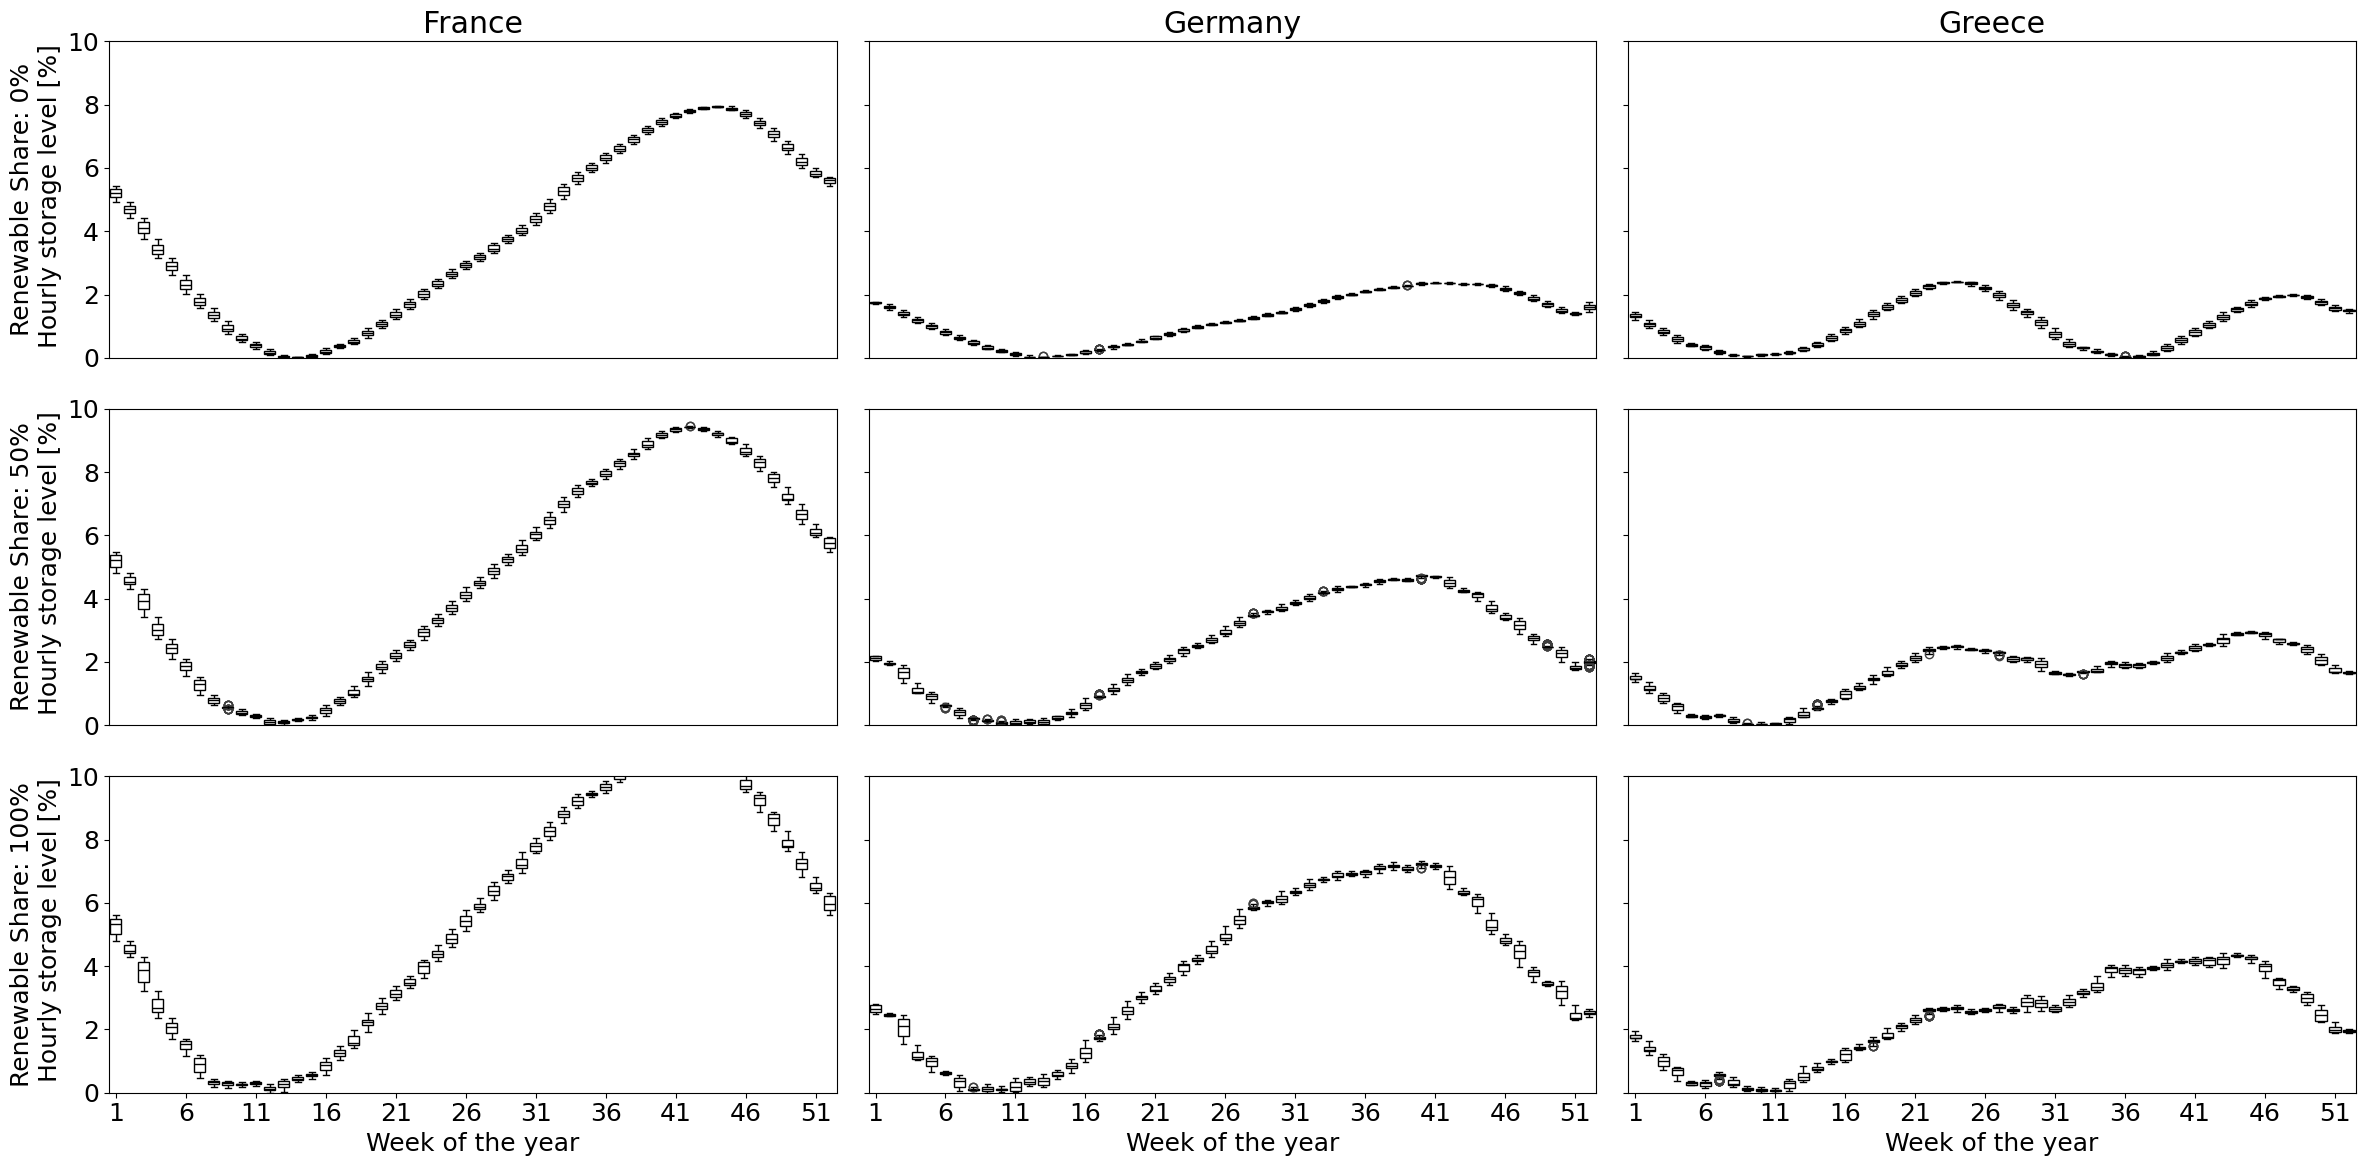

In [20]:
boxplot_by_week(
    df_opt,
    countries,
    re_shares,
    y_var="storageLevel",
    y_label="Hourly storage level [%]",
    y_range=(0, 10),
    mark_zero=False,
    fn_out="../figures/storage_level_boxplot.png",
)